Step-by-Step Overview:
Step 1: Data Loading

Load the CSV file
Inspect structure, data types, and basic statistics
Check for missing values

Step 2: Data Preprocessing

Handle missing values (median for numerical, mode for categorical)
Detect and handle outliers using IQR method
Remove invalid records (volume ≤ 0)
Verify data consistency

Step 3: EDA (Exploratory Data Analysis)

Visualize target variable distribution
Analyze sales by product class, city, and time
Create correlation heatmap
Identify patterns and trends

Step 4: Feature Engineering

Create seasonal features from month
Extract numeric size and calculate price per liter
Encode categorical variables using LabelEncoder
Prepare final feature matrix

Step 5: Train-Test Split & Scaling

Split data 80-20
Standardize numerical features
Preserve encoded categorical features

Step 6: Model Training

Train Linear Regression (baseline)
Train Random Forest Regressor (main model)
Compare performance using R², RMSE, MAE
Analyze feature importance
Visualize predictions vs actual

Step 7: Model Interpretation

Residual analysis
Extract business insights
Document model selection rationale
Provide actionable recommendations

Why Random Forest for this task?

Handles non-linear relationships between features
Captures feature interactions automatically
Robust to outliers
Provides feature importance rankings
Generally performs well on tabular data

# 1- import libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 2- LOAD AND INSPECT DATA

In [71]:
# Load the dataset
df = pd.read_csv('../data/oil_sales_assignment_dataset.csv')
# explore the data
df.head()

,city,store_name,manufacturer,brand,class,size,sku,price_bracket,year,month,value_sales,volume_sales,average_price
0,AL BAHA,HM No 57296 GS-CENTER-AL BAHA MAIN RD AL BAHA,NOVA FOODS,LARA,COCONUT,0.75L,LARA COCONUT 0.75L TWIN PACK,21-30,2024,12,830.86,30.1,27.6
1,AL KHARJ,HM No 55697 GS-CENTER-AL KHARJ MAIN RD AL K...,PALM & GRAIN GROUP,NAJMA,CANOLA,0.5L,NAJMA CANOLA 0.5L TWIN PACK,41-50,2024,10,373.10,9.1,41.0
2,RIYADH,HM No 86781 GS-CENTER-RIYADH MAIN RD RIYADH,AL HILAL INDUSTRIES,BAYTNA,SUNFLOWER,0.75L,BAYTNA SUNFLOWER 0.75L ECO,101+,2023,1,171.70,1.7,101.0
3,DAMMAM,HM No 95753 GS-CENTER-DAMMAM MAIN RD DAMMAM,PALM & GRAIN GROUP,NOUR,CORN,0.6L,NOUR CORN 0.6L TWIN PACK,61-70,2022,2,1226.10,20.1,61.0
4,JAZAN,HM No 56338 GS-CENTER-JAZAN MAIN RD JAZAN,DESERT SUN CO,NOUR,VEGETABLE,1L,NOUR VEGETABLE 1L,81-90,2024,2,996.30,12.3,81.0


In [72]:
# explore the data types
print(df.dtypes)
print(df.describe())

city              object
store_name        object
manufacturer      object
brand             object
class             object
size              object
sku               object
price_bracket     object
year               int64
month              int64
value_sales      float64
volume_sales     float64
average_price    float64
dtype: object
              year        month  value_sales  volume_sales  average_price
count  2000.000000  2000.000000  2000.000000   2000.000000    2000.000000
mean   2022.990500     6.639500   614.839355      9.972100      60.990230
std       0.820211     3.468942   750.794991      9.862369      29.457029
min    2022.000000     1.000000     6.960000      0.500000      11.000000
25%    2022.000000     4.000000   132.000000      2.900000      37.337500
50%    2023.000000     7.000000   368.320000      7.000000      61.000000
75%    2024.000000    10.000000   794.100000     13.800000      81.000000
max    2024.000000    12.000000  6253.200000     81.700000     140.00

In [73]:
# check missing values
print(df.isnull().sum())

# check num of unique values in each coulmn
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

city             0
store_name       0
manufacturer     0
brand            0
class            0
size             0
sku              0
price_bracket    0
year             0
month            0
value_sales      0
volume_sales     0
average_price    0
dtype: int64
city: 12 unique values
store_name: 1997 unique values
manufacturer: 8 unique values
brand: 10 unique values
class: 5 unique values
size: 13 unique values
sku: 1571 unique values
price_bracket: 10 unique values
year: 3 unique values
month: 12 unique values
value_sales: 1306 unique values
volume_sales: 349 unique values
average_price: 149 unique values


# 3- DATA PREPROCESSING

In [74]:
df_clean = df.copy()

# 3.1 Check for Outliers
print("\nDetecting Outliers in Target Variable (volume_sales)...")
Q1 = df_clean['volume_sales'].quantile(0.25)
Q3 = df_clean['volume_sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR (more lenient)
upper_bound = Q3 + 3 * IQR

print(f"  Q1: {Q1}")
print(f"  Q3: {Q3}")
print(f"  IQR: {IQR}")
print(f"  Lower Bound: {lower_bound}")
print(f"  Upper Bound: {upper_bound}")

outliers = df_clean[(df_clean['volume_sales'] < lower_bound) | 
                     (df_clean['volume_sales'] > upper_bound)]
print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")




Detecting Outliers in Target Variable (volume_sales)...
  Q1: 2.9
  Q3: 13.8
  IQR: 10.9
  Lower Bound: -29.800000000000004
  Upper Bound: 46.5
  Number of outliers: 18 (0.90%)


In [75]:
# 3.3 check Invalid Records
print(f"  Negative volume_sales: {(df_clean['volume_sales'] < 0).sum()}")
print(f"  Zero volume_sales: {(df_clean['volume_sales'] == 0).sum()}")

  Negative volume_sales: 0
  Zero volume_sales: 0


In [76]:
# 3.4 Data Consistency Check
"""hecking Data Consistency (value_sales ≈ volume_sales × average_price)"""
df_clean['calculated_value'] = df_clean['volume_sales'] * df_clean['average_price']
df_clean['value_diff'] = abs(df_clean['value_sales'] - df_clean['calculated_value'])
inconsistent = df_clean[df_clean['value_diff'] > 1.0]  # Tolerance of 1 unit
print(f"  Inconsistent records (diff > 1.0): {len(inconsistent)} ({len(inconsistent)/len(df_clean)*100}%)")

  Inconsistent records (diff > 1.0): 0 (0.0%)


# 4- EXPLORATORY DATA ANALYSIS (EDA)

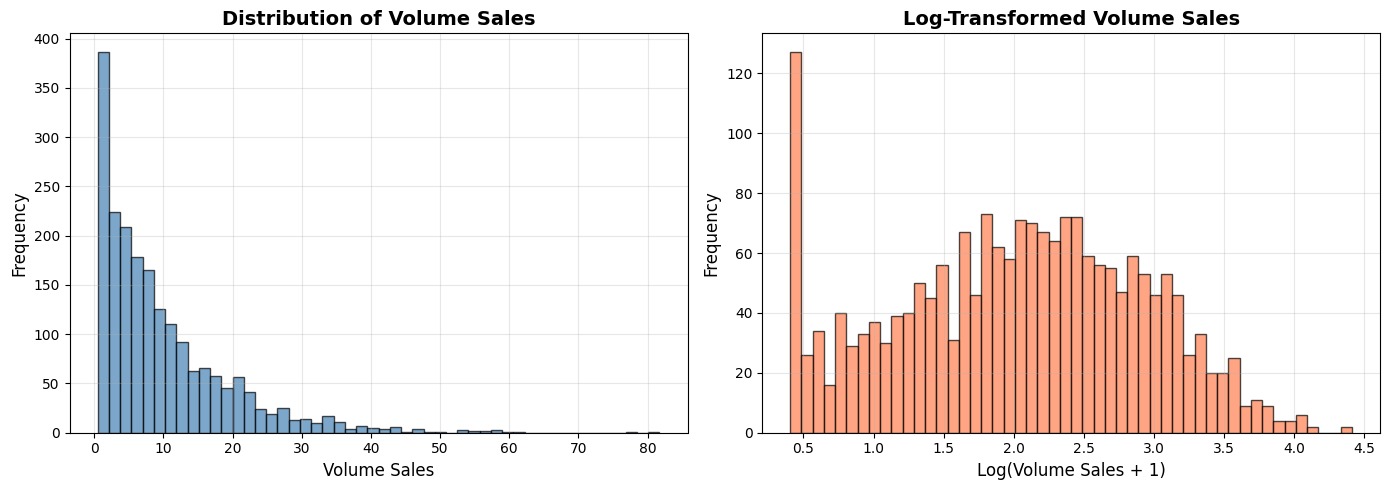

In [77]:
# 4.1 Distribution of Target Variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['volume_sales'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Volume Sales', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Volume Sales', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(np.log1p(df_clean['volume_sales']), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Log(Volume Sales + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Log-Transformed Volume Sales', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Product Class Statistics:
                mean     sum  count
class                              
CORN       10.607769  4232.5    399
CANOLA     10.231088  3949.2    386
SUNFLOWER   9.955425  4221.1    424
COCONUT     9.655970  3881.7    402
VEGETABLE   9.407969  3659.7    389


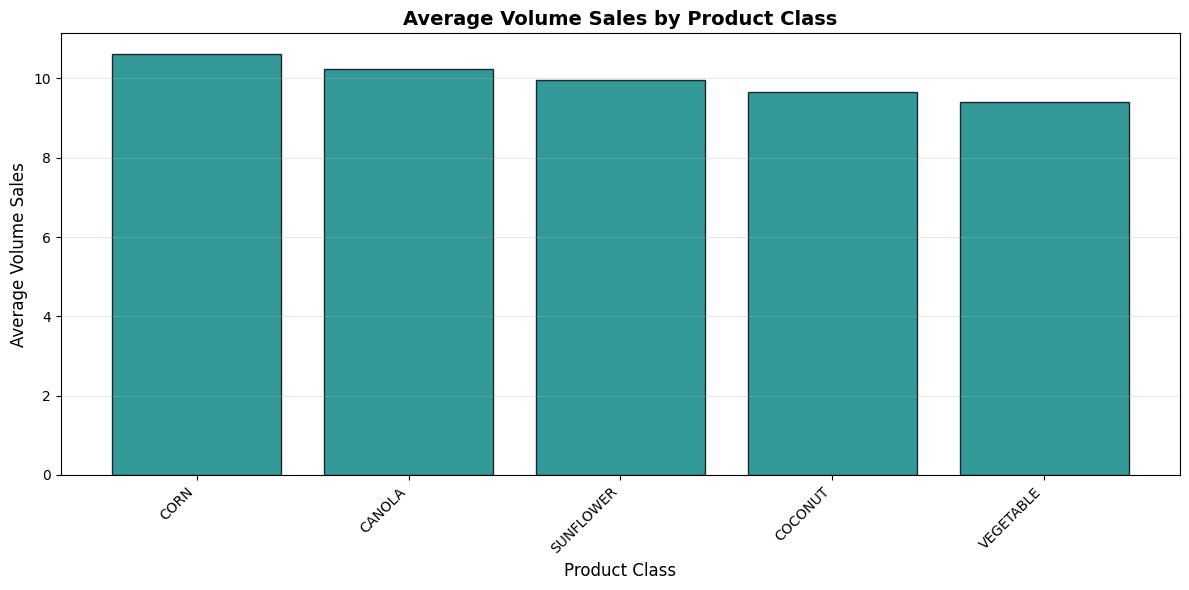

In [78]:

# 4.2 Sales by Product Class
plt.figure(figsize=(12, 6))
class_stats = df_clean.groupby('class')['volume_sales'].agg(['mean', 'sum', 'count']).sort_values('mean', ascending=False)
print("\nProduct Class Statistics:")
print(class_stats)

plt.bar(class_stats.index, class_stats['mean'], alpha=0.8, edgecolor='black', color='teal')
plt.xlabel('Product Class', fontsize=12)
plt.ylabel('Average Volume Sales', fontsize=12)
plt.title('Average Volume Sales by Product Class', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Top 5 Cities by Average Volume Sales:
city
AL BAHA     11.388945
AL AHSA     10.885315
TAIF        10.541216
TABUK       10.532704
AL KHARJ    10.192169
Name: volume_sales, dtype: float64


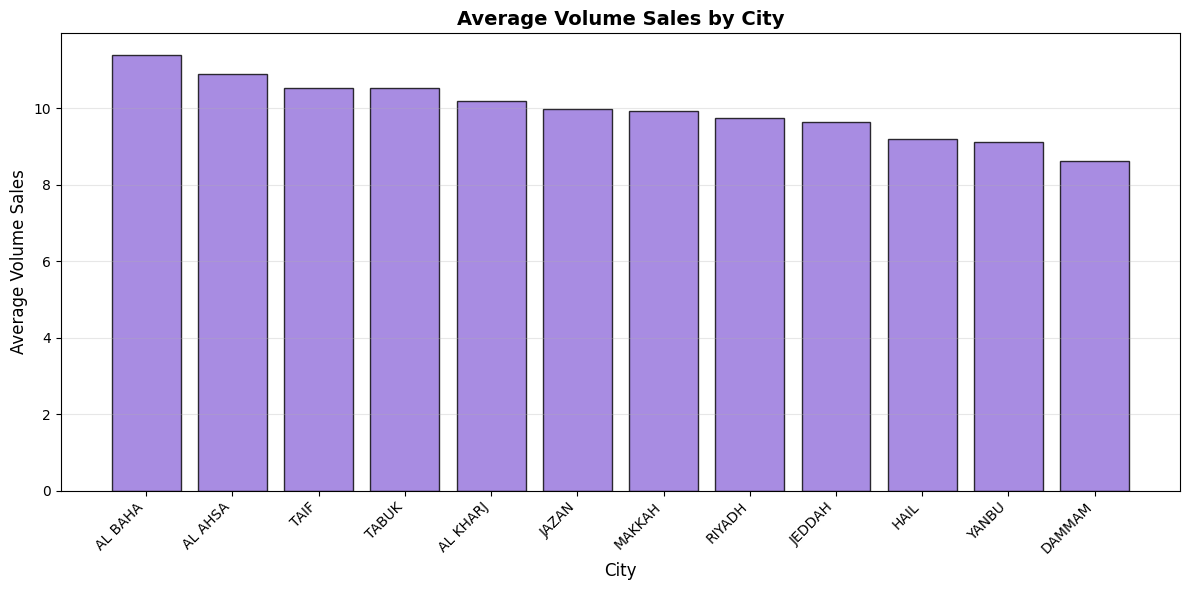

In [79]:
# 4.3 Sales by City
plt.figure(figsize=(12, 6))
city_sales = df_clean.groupby('city')['volume_sales'].mean().sort_values(ascending=False)
print("\nTop 5 Cities by Average Volume Sales:")
print(city_sales.head())

plt.bar(city_sales.index, city_sales.values, alpha=0.8, color='mediumpurple', edgecolor='black')
plt.xlabel('City', fontsize=12)
plt.ylabel('Average Volume Sales', fontsize=12)
plt.title('Average Volume Sales by City', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

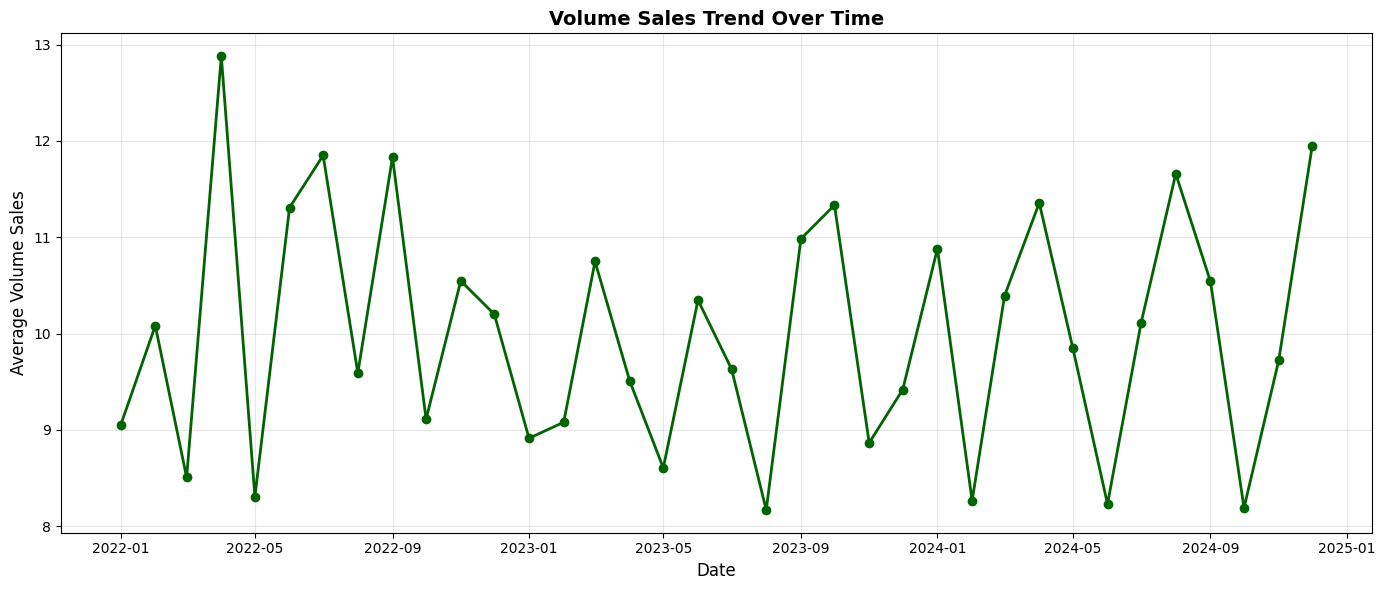

In [80]:
# 4.4 Sales Over Time
time_sales = df_clean.groupby(['year', 'month'])['volume_sales'].mean().reset_index()
time_sales['date'] = pd.to_datetime(time_sales[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
plt.plot(time_sales['date'], time_sales['volume_sales'], marker='o', linewidth=2, 
         markersize=6, color='darkgreen')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Volume Sales', fontsize=12)
plt.title('Volume Sales Trend Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

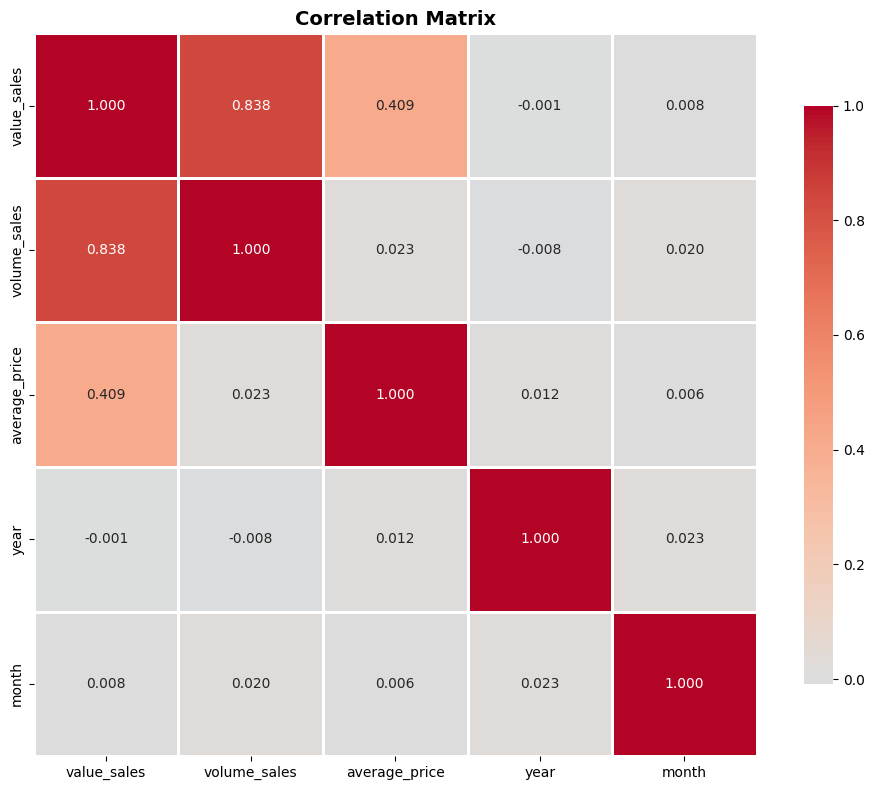


Correlation with Target (volume_sales):
volume_sales     1.000000
value_sales      0.838413
average_price    0.022861
month            0.019631
year            -0.008418
Name: volume_sales, dtype: float64


In [81]:
# 4.5 Correlation Analysis
plt.figure(figsize=(10, 8))
corr_cols = ['value_sales', 'volume_sales', 'average_price', 'year', 'month']
correlation = df_clean[corr_cols].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("\nCorrelation with Target (volume_sales):")
print(correlation['volume_sales'].sort_values(ascending=False))

In [82]:
# 4.6 Sales by Brand
brand_sales = df_clean.groupby('brand')['volume_sales'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
print(brand_sales)

                mean  count
brand                      
ZAHRA      11.265054    186
GULF GOLD  10.747642    212
NAJMA      10.536275    204
SABAYA     10.310000    210
RIMAL      10.261881    202
LARA        9.874737    190
NOUR        9.568085    188
RAWABI      9.264390    205
BAYTNA      9.052222    180
HILAL       8.876233    223


# 5- FEATURE ENGINEERING

In [83]:
# Create a copy for modeling
df_model = df_clean.copy()

# Feature 1: Season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_model['season'] = df_model['month'].apply(get_season)
print(f" Season distribution:\n{df_model['season'].value_counts()}")

 Season distribution:
season
Fall      522
Summer    513
Winter    505
Spring    460
Name: count, dtype: int64


In [84]:
# Feature 2: Extract numeric size
def extract_size_numeric(size_str):
    try:
        import re
        match = re.search(r'([0-9.]+)', str(size_str))
        if match:
            return float(match.group(1))
        return 1.0  # Default
    except:
        return 1.0

df_model['size_numeric'] = df_model['size'].apply(extract_size_numeric)
print(f"Size range: {df_model['size_numeric'].min()} to {df_model['size_numeric'].max()}")

Size range: 0.2 to 10.0


In [85]:
# Feature 3: Price per liter
df_model['price_per_liter'] = df_model['average_price'] / df_model['size_numeric']
print(f"Price per liter range: {df_model['price_per_liter'].min():} to {df_model['price_per_liter'].max():}")

Price per liter range: 2.0 to 505.0


In [86]:
# Feature 4: Brand frequency (market presence)
brand_counts = df_model['brand'].value_counts()
df_model['brand_frequency'] = df_model['brand'].map(brand_counts)
print(f"Brand frequency range: {df_model['brand_frequency'].min()} to {df_model['brand_frequency'].max()}")

Brand frequency range: 180 to 223


In [87]:
# Feature 5: Price bracket numeric
def extract_price_bracket_mid(bracket):
    try:
        import re
        numbers = re.findall(r'\d+', str(bracket))
        if len(numbers) >= 2:
            return (float(numbers[0]) + float(numbers[1])) / 2
        return 30.0  # Default
    except:
        return 30.0

df_model['price_bracket_mid'] = df_model['price_bracket'].apply(extract_price_bracket_mid)
print(f"Price bracket mid range: {df_model['price_bracket_mid'].min()} to {df_model['price_bracket_mid'].max()}")

Price bracket mid range: 15.5 to 95.5


# 6- ENCODE CATEGORICAL VARIABLES

In [88]:
# Select features
categorical_features = ['city', 'manufacturer', 'brand', 'class', 'size', 'price_bracket', 'season']
numerical_features = ['year', 'month', 'value_sales', 'average_price', 
                      'size_numeric', 'price_per_liter', 'brand_frequency', 'price_bracket_mid']
target = 'volume_sales'

# Encode categorical variables
le_dict = {}
df_encoded = df_model.copy()

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le
    print(f" {col}: {len(le.classes_)} unique values did encoded")
print("done for categorical")


# Prepare final feature set
encoded_cat_features = [col + '_encoded' for col in categorical_features]
all_features = numerical_features + encoded_cat_features

# Create feature matrix and target vector
X = df_encoded[all_features]
y = df_encoded[target]

print(f"new shape: {X.shape}")

 city: 12 unique values did encoded
 manufacturer: 8 unique values did encoded
 brand: 10 unique values did encoded
 class: 5 unique values did encoded
 size: 13 unique values did encoded
 price_bracket: 10 unique values did encoded
 season: 4 unique values did encoded
done for categorical
new shape: (2000, 15)


# 7- TRAIN-TEST SPLIT & SCALING

In [89]:
# Split the data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.2f}, Max: {y_train.max():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.2f}, Max: {y_test.max():.2f}")

# Scale numerical features
scaler = StandardScaler()

# Identify numerical feature indices
num_feature_indices = [i for i, col in enumerate(all_features) if col in numerical_features]
print(f"Scaling {len(num_feature_indices)} numerical features")

# Scale only numerical features
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.iloc[:, num_feature_indices] = scaler.fit_transform(
    X_train.iloc[:, num_feature_indices]
)
X_test_scaled.iloc[:, num_feature_indices] = scaler.transform(
    X_test.iloc[:, num_feature_indices]
)

  Training set: 1600 samples (80.0%)
  Test set: 400 samples (20.0%)
  Train - Mean: 9.89, Std: 9.79, Min: 0.50, Max: 81.70
  Test  - Mean: 10.30, Std: 10.15, Min: 0.50, Max: 55.60
Scaling 8 numerical features


# 8- MODEL TRAINING - LINEAR REGRESSION (BASELINE)

In [90]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Evaluate
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
lr_train_mae = mean_absolute_error(y_train, y_pred_lr_train)
lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)

print("\nLinear Regression Performance:")
print(f"  Training R²:   {lr_train_r2}")
print(f"  Test R²:       {lr_test_r2}")
print(f"  Training RMSE: {lr_train_rmse}")
print(f"  Test RMSE:     {lr_test_rmse}")
print(f"  Training MAE:  {lr_train_mae}")
print(f"  Test MAE:      {lr_test_mae}")

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, 
                            scoring='r2', n_jobs=-1)
print(f"\n CV R² Score: {cv_scores.mean()} (+/- {cv_scores.std()})")



Linear Regression Performance:
  Training R²:   0.8305297112521552
  Test R²:       0.8081258070884424
  Training RMSE: 4.029358490022603
  Test RMSE:     4.439970797844104
  Training MAE:  2.5648581306855847
  Test MAE:      2.666969850523296

 CV R² Score: 0.8232410227953373 (+/- 0.0143873868113307)


# 9- MODEL TRAINING - RANDOM FOREST

In [91]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate
rf_train_r2 = r2_score(y_train, y_pred_rf_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)

print("\nRandom Forest Performance:")
print(f"  Training R²:   {rf_train_r2}")
print(f"  Test R²:       {rf_test_r2}")
print(f"  Training RMSE: {rf_train_rmse}")
print(f"  Test RMSE:     {rf_test_rmse}")
print(f"  Training MAE:  {rf_train_mae}")
print(f"  Test MAE:      {rf_test_mae}")

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
print(f"\n CV R² Score: {cv_scores_rf.mean()} (+/- {cv_scores_rf.std()})")



Random Forest Performance:
  Training R²:   0.9828989534764855
  Test R²:       0.979427109383229
  Training RMSE: 1.2799719948577664
  Test RMSE:     1.453849626469379
  Training MAE:  0.34565815560138063
  Test MAE:      0.46450253850040113

 CV R² Score: 0.9599050968196282 (+/- 0.01182973881871719)


# 10- MODEL COMPARISON

In [92]:
# Create comparison dataframe
comparison_data = {
    'Linear Regression': {
        'Train R²': lr_train_r2,
        'Test R²': lr_test_r2,
        'Train RMSE': lr_train_rmse,
        'Test RMSE': lr_test_rmse,
        'Test MAE': lr_test_mae,
        'CV R² Mean': cv_scores.mean()
    },
    'Random Forest': {
        'Train R²': rf_train_r2,
        'Test R²': rf_test_r2,
        'Train RMSE': rf_train_rmse,
        'Test RMSE': rf_test_rmse,
        'Test MAE': rf_test_mae,
        'CV R² Mean': cv_scores_rf.mean()
    }
}

comparison_df = pd.DataFrame(comparison_data).T
print(comparison_df)


                   Train R²   Test R²  Train RMSE  Test RMSE  Test MAE  \
Linear Regression  0.830530  0.808126    4.029358   4.439971  2.666970   
Random Forest      0.982899  0.979427    1.279972   1.453850  0.464503   

                   CV R² Mean  
Linear Regression    0.823241  
Random Forest        0.959905  


# 11- FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
              feature  importance
          value_sales    0.806575
        average_price    0.180142
    price_bracket_mid    0.003932
price_bracket_encoded    0.002624
        class_encoded    0.001185
      price_per_liter    0.001105
         city_encoded    0.000823
         size_encoded    0.000748
      brand_frequency    0.000571
        brand_encoded    0.000523
 manufacturer_encoded    0.000474
                month    0.000450
         size_numeric    0.000370
       season_encoded    0.000279
                 year    0.000200


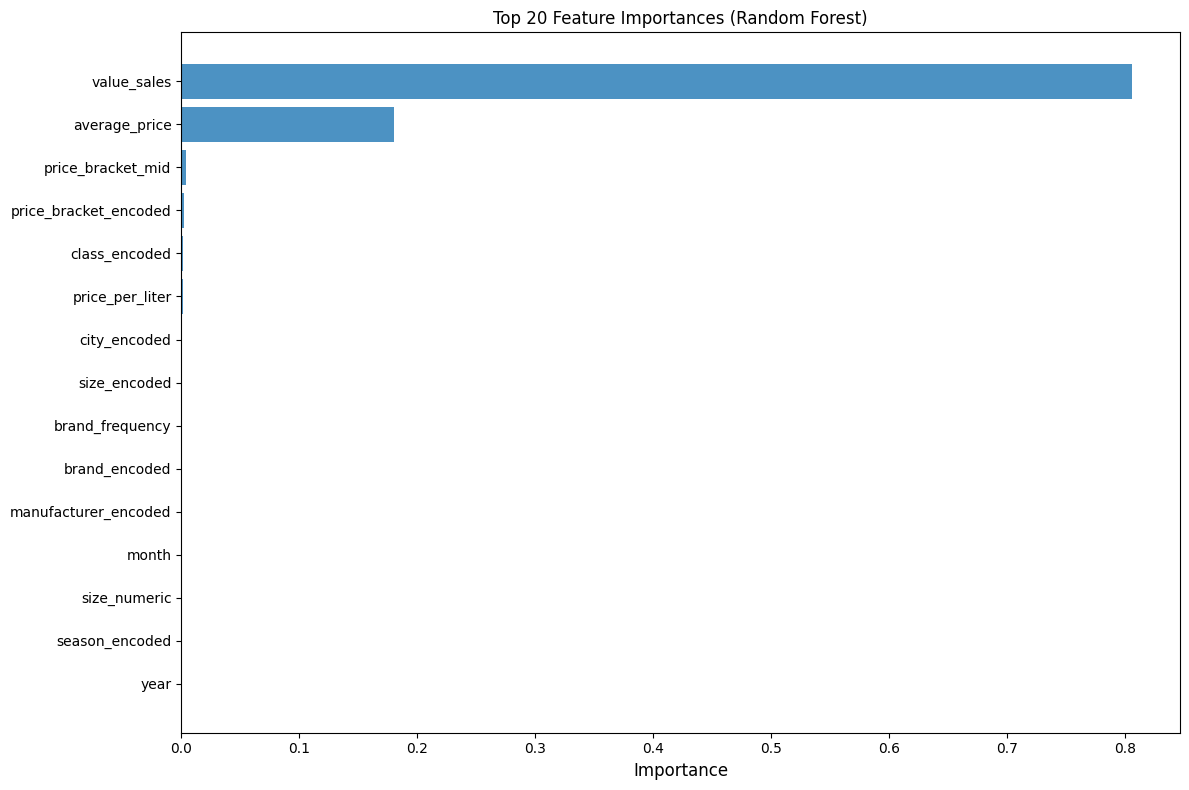

In [93]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 12- MODEL VISUALIZATION

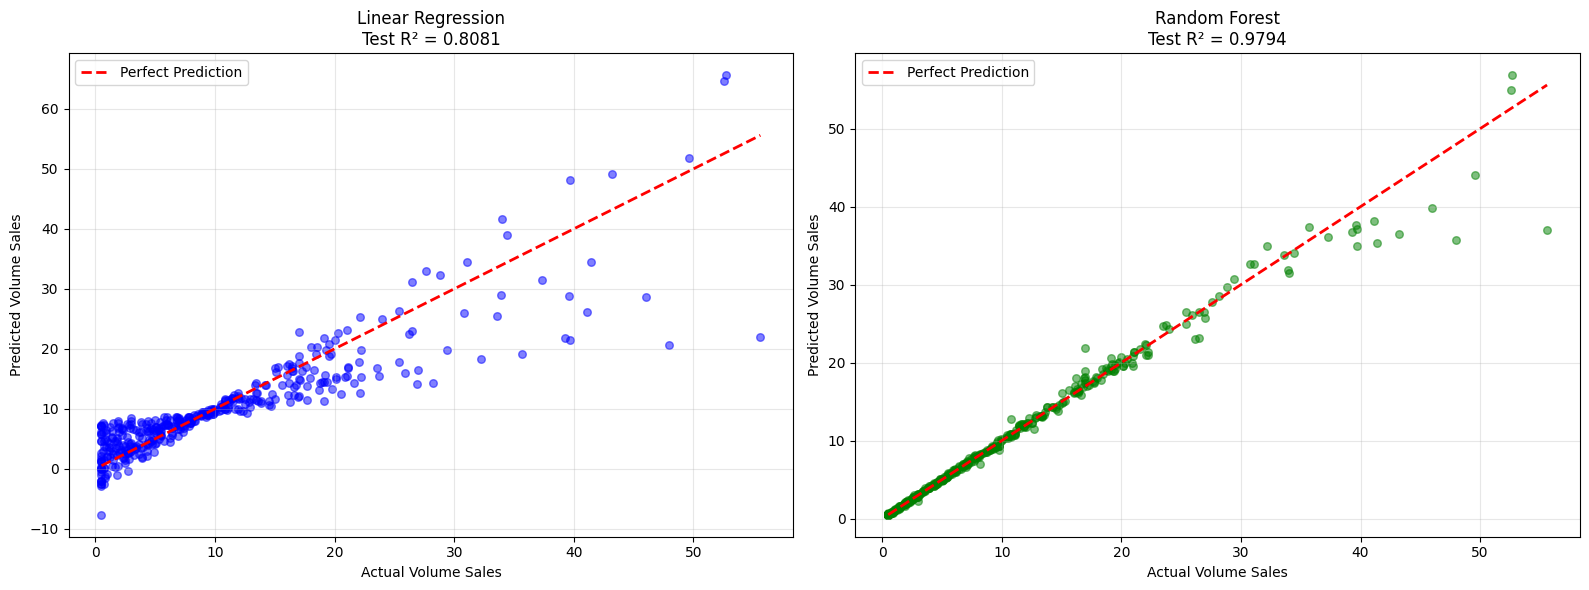

In [94]:
# Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr_test, alpha=0.5, s=30, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Volume Sales')
axes[0].set_ylabel('Predicted Volume Sales')
axes[0].set_title(f'Linear Regression\nTest R² = {lr_test_r2:.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_pred_rf_test, alpha=0.5, s=30, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Volume Sales')
axes[1].set_ylabel('Predicted Volume Sales')
axes[1].set_title(f'Random Forest\nTest R² = {rf_test_r2:.4f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()